In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import fmplib as fmp

In [2]:
#get audio
snd1 = fmp.load_wav('wav/Twinkle1.wav')

In [3]:
#make stft with hanning window (N=4096, H=1024, zp factor = 4)
#plot stft
N = 4096
H = 1024
fs = 22050
X = fmp.stft(snd1, N, H, zp_factor=4)
X = np.log10(1+10*X)

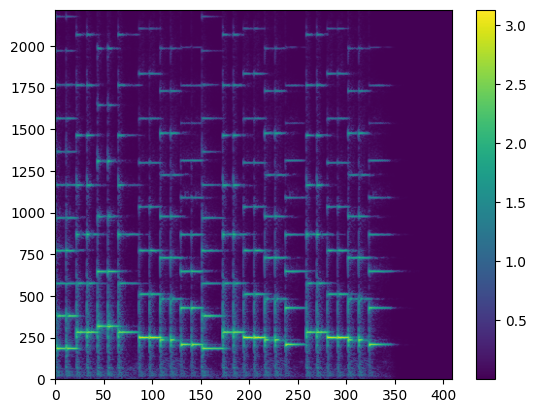

In [4]:
#consider k within k range wanted
k_max = round(N*12000/fs)
k_min = round(N*65/fs) #C2 for now
plt.imshow(abs(X[k_min:k_max+1, :]), origin='lower', aspect='auto')
plt.colorbar()

C:\Users\my537\AppData\Local\Temp\ipykernel_13632\1560333100.py:8: RuntimeWarning: divide by zero encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)
C:\Users\my537\AppData\Local\Temp\ipykernel_13632\1560333100.py:8: RuntimeWarning: invalid value encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)


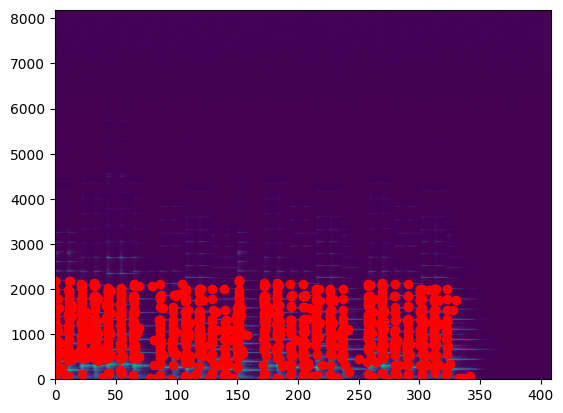

In [62]:
#calculate tonality at k
def tonality(stft):
    return amp_tonality(stft)*peak_tonality(stft, 8)
    pass

def amp_tonality(stft):
    shift_stft = np.pad(stft[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=0)
    return abs((abs(stft)-abs(shift_stft))/shift_stft)

def peak_tonality(stft, m):
    pad_stft = np.pad(stft, ((m, m), (0, 0)), mode='constant', constant_values=0)
    return (abs(pad_stft[:len(stft),:])-abs(pad_stft[2*m:,:]))/abs(stft)

def find_intersection(matrix1, matrix2):
    set1 = set(map(tuple, matrix1))
    set2 = set(map(tuple, matrix2))
    return np.array(list(set1 & set2)).T

T = tonality(X)
#get T threshold and area peaks
temp_peaks = np.array(np.where((T > .7) & (abs(X) > .1*np.max(abs(X)))))
area_peaks = fmp.find_area_peaks(abs(X), 16, 4).T #arbitrary
area_peaks[[0, 1]] = area_peaks[[1, 0]] #same 'values' at 0 and 1
T_peaks = find_intersection(area_peaks.T, temp_peaks.T)

#get k threshold
thresh_i = np.where((T_peaks[0] >= k_min) & (T_peaks[0] <= k_max))
T_peaks = T_peaks[:, thresh_i[0]]

plt.imshow(abs(X), origin='lower', aspect='auto')
plt.plot(T_peaks[1], T_peaks[0]-k_min, 'ro')

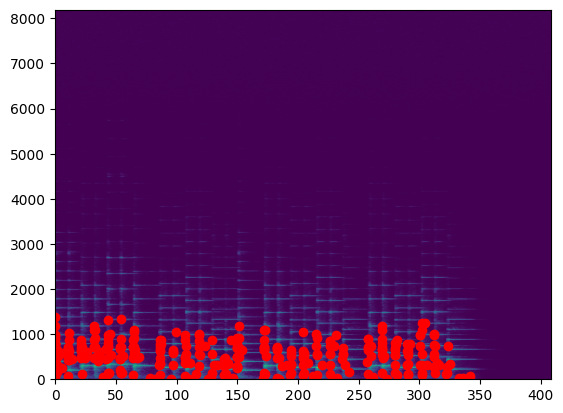

In [64]:
sal_stft = X**.25
def calc_saliance(t_peaks, stft): #make sure to have transposed version
    vals = stft[t_peaks[0], t_peaks[1]] + stft[2*t_peaks[0], t_peaks[1]] + stft[3*t_peaks[0], t_peaks[1]]
    threshold = .98**25*np.max(vals) #change later?
    return t_peaks.T[vals > threshold]
    pass

saliance_peaks = calc_saliance(T_peaks, sal_stft).T #same dim as T_peaks
plt.imshow(abs(X), origin='lower', aspect='auto')
plt.plot(saliance_peaks[1], saliance_peaks[0]-k_min, 'ro')

In [65]:
#Check pitches of saliance peaks
#get pitches
pitch_time = np.zeros(saliance_peaks.shape)
#get time
pitch_time[1] = saliance_peaks[1]*H/fs
#get pitches
pitch_time[0] = saliance_peaks[1]*fs/N #get frequency
pitch_time[0] = fmp.freq_to_pitch(pitch_time[0])

C:\Users\my537\AppData\Local\Temp\ipykernel_13632\3727046955.py:8: RuntimeWarning: divide by zero encountered in log2
  pitch_time[0] = fmp.freq_to_pitch(pitch_time[0])


In [66]:
#some pre-whitening
def smoothing(stft, alpha):
    return stft

def make_MCACF(shape, c):
    W_c_1d = np.arange(shape[0]).astype(float) #has all k values
    k_c = k_min*2**c

    W_c_1d[:round(k_c/4+.5)] = 0
    W_c_1d[round(k_c/4+.5):k_c] = 4/(3*k_c)*W_c_1d[round(k_c/4+.5):k_c]-1/3
    W_c_1d[k_c: 2*k_c+1] = 1
    W_c_1d[2*k_c+1:20*k_c] = -1/(18*k_c)*W_c_1d[2*k_c+1:20*k_c]+10/9
    W_c_1d[20*k_c:] = 0

    # W_c = np.repeat(W_c_1d[:, np.newaxis], shape[1], axis=1)
    return W_c_1d[:, np.newaxis]

def make_W_c(num):
    W_c = []
    for c in range(num):
        temp_prime = make_MCACF(X.shape, c)
        # W_c.append(temp_prime/sum(temp_prime[:, 0])) #different sum?
        W_c.append(temp_prime/sum(temp_prime)) #different sum? should this be 2d?
    return W_c

E_prime = np.ones(X.shape)
E = smoothing(E_prime, 20/N)
X_w_prime = X/E

#might be sus
X_w1 = X_w_prime * np.sqrt(np.sum(X**2)/np.sum(X_w_prime**2)) #sqrt is a number
X_w2 = X_w_prime * np.sqrt((X**2)/(X_w_prime**2)) #sqrt is a matrix

W_c = make_W_c(5)

# A_c = []
# for c in range(5):
#     temp = np.sqrt(X_w1*N)*W_c[c]
#     A_c.append(np.fft.ifft2(temp))
#     plt.figure()
#     plt.imshow(abs(A_c[c]), origin='lower', aspect='auto')
#     plt.colorbar()
#     # print(A_c[c][])
#     print(np.unravel_index(np.argmax(A_c[c], axis=None), A_c[c].shape))

In [67]:
def make_A_c(X, W_c, N, H):
    A_c = []
    for c in range(len(W_c)):
        val = np.sqrt(X*N)*W_c[c]
        # A_c.append(fmp.istft(val, H))
        A_c.append(np.fft.ifft2(val))
        break
    return A_c

A_c = make_A_c(X_w1, W_c, N, H)

    